<div class="alert alert-success">
    <h1 align="center">Lesson 3: Object Classification with Localization</h1>
    <h3 align="center"><a href="http://www.snrazavi.ir">Seyed Naser RAZAVI</a></h3>
</div>

## Introduction

<img src='imgs/fish-competition-bb.png' width='90%'/>

<h6 align='center'>[Kaggle fisheries competition](https://www.kaggle.com/c/the-nature-conservancy-fisheries-monitoring)</h6>

<h6>Goal:</h6>
- Detecting the species of the fish in a fishing boat, based on images captured from various angles.
- Classes: `ALB`, `BET`, `DOL`, `LAG`, `SHARK`, `YFT`, `OTHER`, `NoF` (no fish).

<img src='imgs/kaggle-fish-types.png' width='80%'/>

## Libraries

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys
import json
import visdom
import numpy as np
import matplotlib.pyplot as plt

from glob import glob
from tqdm import tqdm
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.models as models
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from utils import to_var
from data_utils import create_validation_data
from vis_utils import imshow, plot_bbox, PlotLoss, ShowSample

np.set_printoptions(precision=2)

Helper functions

In [2]:
def get_model(model_name, pretrained=True):
    return models.__dict__[model_name](pretrained)


def read_annotations(path):
    """ Read Bounding Boxes from a json file.
    """
    anno_classes = [f.split('_')[0] for f in os.listdir(path)]
    bb_json = {}
    
    for c in anno_classes:
        j = json.load(open(f'{path}/{c}_labels.json', 'r'))
        for l in j:
            if 'annotations' in l and len(l['annotations']) > 0:
                fname = l['filename'].split('/')[-1]
                bb_json[fname] = sorted(
                    l['annotations'], key=lambda x: x['height'] * x['width'])[-1]
    return bb_json

## Data

In [3]:
DATA_DIR = "D:/datasets/kaggle/fish"
train_dir = f'{DATA_DIR}/train'
valid_dir = f'{DATA_DIR}/valid'
anno_dir = f'{DATA_DIR}/annotations'

# hyper-parameters
sz = 300  # image size
bs = 32   # batch size
model_name = 'resnet34'
num_classes = 8
num_epochs = 50
alpha = 0.5  # classification loss coeff

### Read annotations (bounding boxes)

In [4]:
bb_json = read_annotations(anno_dir)

In [5]:
print(list(bb_json.keys())[:5])

['img_07917.jpg', 'img_07915.jpg', 'img_07914.jpg', 'img_07912.jpg', 'img_07904.jpg']


In [6]:
print(bb_json['img_07917.jpg'])

{'class': 'rect', 'height': 151.06975503141317, 'width': 383.68430384213445, 'x': 547.1578480789353, 'y': 193.3597426816281}


### Files structure

In [7]:
print(os.listdir(DATA_DIR))

['annotations', 'sample', 'test', 'train', 'valid']


In [8]:
# all images for each fish class is in a separate directory
print(os.listdir(f'{DATA_DIR}/train'))

['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']


In [9]:
files = glob(f'{DATA_DIR}/train/ALB/*.*')
files[:5]

['D:/datasets/kaggle/fish/train/ALB\\img_00003.jpg',
 'D:/datasets/kaggle/fish/train/ALB\\img_00010.jpg',
 'D:/datasets/kaggle/fish/train/ALB\\img_00012.jpg',
 'D:/datasets/kaggle/fish/train/ALB\\img_00015.jpg',
 'D:/datasets/kaggle/fish/train/ALB\\img_00019.jpg']

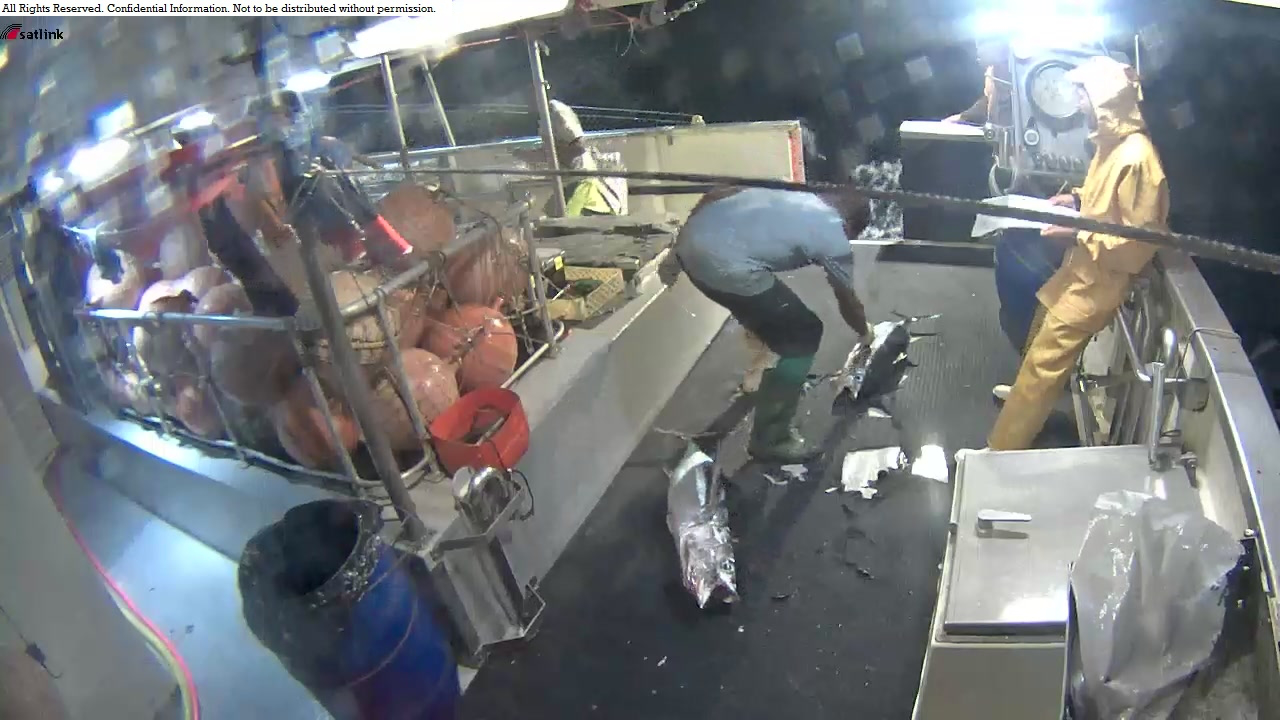

In [10]:
Image.open(files[1])

### Annotations

In [11]:
anno_files = os.listdir(anno_dir)
anno_files

['alb_labels.json',
 'bet_labels.json',
 'dol_labels.json',
 'lag_labels.json',
 'other_labels.json',
 'shark_labels.json',
 'yft_labels.json']

In [12]:
filename = f'{anno_dir}/{anno_files[0]}'
# print(open(filename, 'r').read())

### Create validation data

In [13]:
if not os.path.exists(valid_dir):
    create_validation_data(train_dir, valid_dir, split=0.2, ext='jpg')

### Fish Dataset

In [14]:
class FishDataset(Dataset):
    def __init__(self, ds, bboxes, sz=299):
        """ Prepare fish dataset
        
        Inputs:
            root: the directory which contains all required data such as images, labels, etc.
            ds: torchvision ImageFolder dataset.
            bboxes: a dictionary containing the coordinates of the bounding box in each images
            transforms: required transformations on each image
        """
        self.imgs = ds.imgs          # images and labels
        self.classes = ds.classes    # class names
        self.bboxes = bboxes         # bounding boxes
        self.sz = sz                 # image size
        
        self.tfms = transforms.Compose([
            transforms.Resize((sz, sz)),
            transforms.ColorJitter(0.2, 0.2, 0.2, 0.02),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    
    def __getitem__(self, index):
        img, lbl = self.imgs[index]
        
        # get bounding box
        img_name = os.path.basename(img)
        if img_name in self.bboxes.keys():
            bbox = self.bboxes[img_name]
        else:
            bbox = {'class': 'rect', 'height': 0., 'width': 0., 'x': 0., 'y': 0.}
            
        # read image and perform transformations
        image = Image.open(img).convert('RGB')
        image_w, image_h = image.size
        
        w_scale = sz / image_w
        h_scale = sz / image_h
        
        # transformations
        image_tensor = self.tfms(image)
        
        # normalize and scale bounding box
        bx, by, bw, bh = bbox['x'], bbox['y'], bbox['width'], bbox['height']
        bx, bw = (bx * w_scale) / sz, (bw * w_scale) / sz
        by, bh = (by * h_scale) / sz, (bh * h_scale) / sz
        
        # create target tensor (location and classification result)
        target_tensor = torch.zeros(4 + len(self.classes))
        target_tensor[:4] = torch.FloatTensor([bx, by, bw, bh])
        target_tensor[4 + lbl] = 1
        
        # return image tensor, label tensor and bounding box tensor
        return image_tensor, target_tensor, (image_w, image_h)
    
    def __len__(self):
        return len(self.imgs)

### Training and Validation dataset

In [15]:
# training data
train_data = datasets.ImageFolder(train_dir)
train_ds = FishDataset(train_data, bb_json, sz=sz)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

# validation data
valid_data = datasets.ImageFolder(valid_dir)
valid_ds = FishDataset(valid_data, bb_json, sz=sz)
valid_dl = DataLoader(valid_ds, batch_size=bs, shuffle=False)

### Visulaize data

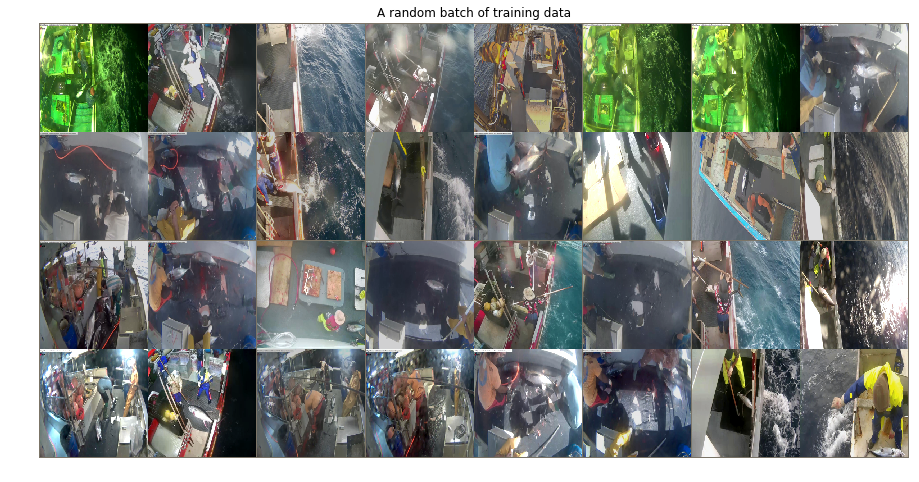

In [16]:
dataiter = iter(train_dl)
imgs, targets, sizes = next(dataiter)
img = torchvision.utils.make_grid(imgs, nrow=8)
plt.figure(figsize=(16, 8))
imshow(img, title='A random batch of training data')

torch.Size([3, 300, 300])
[0.2  0.59 0.11 0.08 1.   0.   0.   0.   0.   0.   0.   0.  ]
ALB


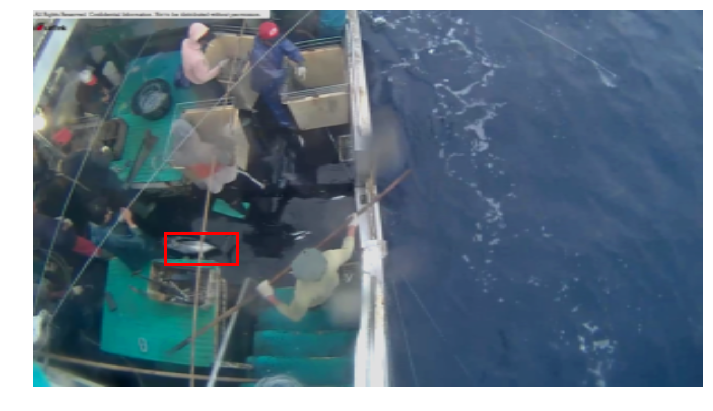

In [17]:
# get one random data from training data
rnd_idx = np.random.choice(len(train_ds))
img_tensor, target_tensor, (img_w, img_h) = train_ds[rnd_idx]

# print size, label, and bounding box
print(img_tensor.size())
print(target_tensor.numpy())
bb = target_tensor[:4]
lbl = np.argmax(target_tensor) - 4
print(train_ds.classes[lbl])

# plot image and bounding box
plot_bbox(img_tensor, bb, img_w, img_h)

## Classification with Localization

<img src='imgs/localization.png' width='90%'/>

### Model

In [18]:
class ClassifierLocalizer(nn.Module):
    def __init__(self, model_name, num_hidden=128, num_classes=8):
        super(ClassifierLocalizer, self).__init__()
        self.num_classes = num_classes
        self.num_hidden = num_hidden
        
        # create cnn model
        cnn = get_model(model_name)

        # remove fc layers from cnn and add a new fc layer
        if hasattr(cnn, 'fc'):
            self.num_features = cnn.fc.in_features
        else:
            self.num_features = cnn.classifier.in_features
    
        fc = nn.Sequential(
            nn.Linear(self.num_features, self.num_hidden),
            nn.BatchNorm1d(self.num_hidden),
            nn.LeakyReLU(0.1, inplace=True)
        )
        
        if hasattr(cnn, 'fc'):
            cnn.fc = fc
        else:
            cnn.classifier = fc

        self.features = cnn
        
        # bounding box
        self.loc = nn.Linear(self.num_hidden, 4)
        # class = 8
        self.cls = nn.Linear(self.num_hidden, self.num_classes)
    
    def forward(self, x):
        x = self.features(x)      # extract features
        loc_out = self.loc(x)     # bbox location
        cls_out = self.cls(x)     # class scores
        
        return F.sigmoid(loc_out), F.sigmoid(cls_out)

### Loss Function

Loss function has two parts:
- Mean of Squared Errors (for classification, using one-hot encoding).
- Mean of Squared Errors (for regression).

In [19]:
def l2_loss(output, target, mask=None):
    """ L2 loss function
    
    Inputs: 
        output: predicted outputs, bs * 8
        target: true outputs, bs * 8
    """
    dist = torch.pow(output - target, 2)
    flat = torch.sum(dist, 1).view(-1)
    return torch.mean(mask * flat) if mask is not None else torch.mean(flat)


def loss_func(output, target, alpha):
    output_loc, output_cls = output
    target_loc = target[:, :4]
    target_cls = target[:, 4:]

    mask = to_var((torch.max(output_cls.data, dim=1)[1] != 4).float())
    loc_loss = l2_loss(output_loc, target_loc, mask)
    cls_loss = l2_loss(output_cls, target_cls)
    
    total = loc_loss + (alpha * cls_loss)
    return total, loc_loss, cls_loss

### Training

In [20]:
model = ClassifierLocalizer(model_name)
if torch.cuda.is_available(): model = model.cuda()
    
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.95)

### Visdom for visualization

Before executing next cell, run the following command on the command prompt:
<pre>
python -m visdom.server
</pre>
If you hava Anaconda, then you can easily install *visdom* by executing the command below:
<pre>
conda install -c conda-forge visdom 
</pre>

In [21]:
viz = visdom.Visdom()

ttl_loss = PlotLoss(viz, opts=dict(title="total loss"))
loc_loss = PlotLoss(viz, opts=dict(title="localization loss"))
cls_loss = PlotLoss(viz, opts=dict(title="classification loss"))

sample1 = ShowSample(model, viz, f'{valid_dir}/ALB/img_00206.jpg', sz, win="test1")
sample2 = ShowSample(model, viz, f'{valid_dir}/YFT/img_00004.jpg', sz, win="test2")
sample3 = ShowSample(model, viz, f'{valid_dir}/SHARK/img_01524.jpg', sz, win="test3")

In [22]:
def train_step(model, optimizer, train_dl, verbose=0, alpha=0.2):
    
    model.train()  # training phase
    
    epoch_loss = 0.0
    epoch_cls_loss = 0.0
    epoch_loc_loss = 0.0
    
    for data, target, _ in tqdm(train_dl, desc='train'):
        data, target = to_var(data), to_var(target)

        # forward
        output = model(data)
        
        # loss
        loss, loc_loss, cls_loss = loss_func(output, target, alpha)
        
        epoch_loss += loss.data[0] / len(train_dl)
        epoch_loc_loss += loc_loss.data[0] / len(train_dl)
        epoch_cls_loss += cls_loss.data[0] / len(train_dl)
        
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if verbose > 0:
            print(f"loss:{loss.data[0]}")
            print(f"loc loss:{loc_loss.data[0]}")
            print(f"cls loss:{cls_loss.data[0]}")

    return epoch_loss, epoch_loc_loss, epoch_cls_loss


def evaluate_step(model, valid_dl, alpha=0.2):
    model.eval()  # testing phase

    epoch_loss = 0.0
    epoch_cls_loss = 0.0
    epoch_loc_loss = 0.0
    
    for data, target, _ in tqdm(valid_dl, desc="valid"):
        data, target = to_var(data), to_var(target)
        
        # forward 
        output = model(data)
        
        # loss
        loss, loc_loss, cls_loss = loss_func(output, target, alpha)
        
        epoch_loss += loss.data[0] / len(valid_dl)
        epoch_loc_loss += loc_loss.data[0] / len(valid_dl)
        epoch_cls_loss += cls_loss.data[0] / len(valid_dl)
        
    return epoch_loss, epoch_loc_loss, epoch_cls_loss

In [ ]:
best_loss = float('inf')
best_weights = None

for epoch in range(num_epochs):
    
    # run one epoch of training and validate model on validation dataset
    trn_loss, trn_loc_loss, trn_cls_loss = train_step(model, optimizer, train_dl, alpha=alpha)
    val_loss, val_loc_loss, val_cls_loss = evaluate_step(model, valid_dl, alpha=alpha)    

    # visualization using Visddom
    ttl_loss.append([trn_loss, val_loss])
    loc_loss.append([trn_loc_loss, val_loc_loss])
    cls_loss.append([trn_cls_loss, val_cls_loss])

    sample1.show()
    sample2.show()
    sample3.show()

    # save model
    if val_loss < best_loss:
        best_loss = val_loss
        best_weights = model.state_dict().copy()
        torch.save(model.state_dict(), 'models/{}-sz-{}-epoch-{:2d}-loss-{:.5f}-{:.5f}.pth'.format(
            model_name, sz, epoch, trn_loss, val_loss))
    
    scheduler.step()  # decrease lr after every epoch
    alpha *= 0.95

model.load_state_dict(best_weights)

valid: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:42<00:00,  1.77s/it]


valid: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:43<00:00,  1.80s/it]


### Predicting bounding boxes

In [ ]:
# load weights
model.load_state_dict(torch.load('models/resnet34-sz-350-epoch-43-loss-0.00274-0.01050.pth'))

In [ ]:
imgs, targets, sizes = next(iter(valid_dl))
locs, scores = model(to_var(imgs, volatile=True))

scores = scores.data.cpu().numpy()
locs = locs.data.cpu().numpy()

for i in range(locs.shape[0]):
    pred_lbl = np.argmax(scores[i])
    pred_bb = locs[i].tolist()
    w, h = sizes[0][i], sizes[1][i]
    print(valid_ds.classes[pred_lbl])
    plot_bbox(imgs[i], pred_bb, w, h)

## Other applications

### Key point detection

<img src='imgs/key_points.png' width='80%'/>

### Pose estimation

<img src='imgs/pose.png' width='80%'/>